## Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 2: Load and Parse the Raw Dataset

In [2]:
import pandas as pd
import numpy as np

file_path = '/content/drive/My Drive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

data = []
with open(file_path) as f:
    for line in f:
        try:
            parts = line.strip().split(',')
            if len(parts) >= 6:
                user_id, activity, timestamp, x, y, z = parts[0], parts[1], parts[2], float(parts[3]), float(parts[4]), float(parts[5].split(';')[0])
                data.append([user_id, activity, timestamp, x, y, z])
        except:
            continue

columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.DataFrame(data, columns=columns)
print(df.head())

  user activity       timestamp         x          y         z
0   33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1   33  Jogging  49106062271000  5.012288  11.264028  0.953424
2   33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3   33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4   33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [3]:
df

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098199,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098200,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098201,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['x'].plot(kind='hist', bins=20, title='x')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['z'].plot(kind='hist', bins=20, title='z')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('user').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('activity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='x', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='y', y='z', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('user')):
  _plot_series(series, series_name, i)
  fig.legend(title='user', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['x']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('x')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('user')):
  _plot_series(series, series_name, i)
  fig.legend(title='user', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('activity')):
  _plot_series(series, series_name, i)
  fig.legend(title='activity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['x'].plot(kind='line', figsize=(8, 4), title='x')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['z'].plot(kind='line', figsize=(8, 4), title='z')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['activity'].value_counts()
    for x_label, grp in _df_17.groupby('user')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('user')
_ = plt.ylabel('activity')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['user'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='index', y='user', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['user'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='x', y='user', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['activity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='x', y='activity', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Step 3: Feature Extraction via Sliding Window

In [ ]:
def extract_features(df, window_size=200):
    X, y = [], []
    for i in range(0, len(df) - window_size, window_size):
        window = df.iloc[i:i+window_size]
        x_vals = window['x'].values
        y_vals = window['y'].values
        z_vals = window['z'].values

        features = []
        for axis in [x_vals, y_vals, z_vals]:
            features += [
                np.mean(axis), np.std(axis), np.min(axis), np.max(axis),
                np.median(axis), np.percentile(axis, 25), np.percentile(axis, 75)
            ]
        label = window['activity'].mode()[0]
        X.append(features)
        y.append(label)
    return np.array(X), np.array(y)

X, y = extract_features(df)
print("Shape of X (Number of samples, Number of features per sample) = ",X.shape)
print("Shape of Y (Number of labels) = ",y.shape)

X (Number of samples, Number of features per sample) =  (5491, 21)
Y (Number of labels) =  (5491,)


## Step 4: Encode Labels and Train-Test Split

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## Step 5: Train Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9253867151956324

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.87      0.76      0.81        97
     Jogging       0.94      0.98      0.96       356
     Sitting       0.96      0.95      0.96        58
    Standing       0.98      0.98      0.98        42
    Upstairs       0.88      0.72      0.80       138
     Walking       0.92      0.98      0.95       408

    accuracy                           0.93      1099
   macro avg       0.93      0.89      0.91      1099
weighted avg       0.92      0.93      0.92      1099



## Step 6: Visualization of Classification Results

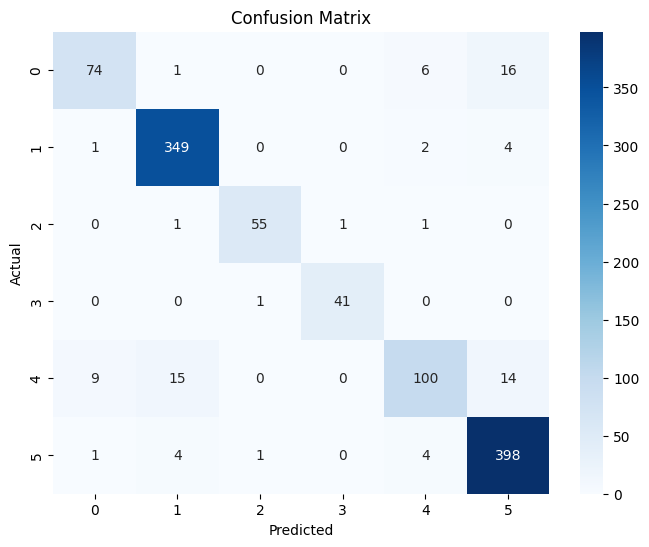

In [ ]:
## Step 6: Visualization of Classification Results

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()